# Create a Customer Segmentation Report for Arvato Financial Services

# Introduction

### Project Overview

In this project, we will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. we'll use **unsupervised learning techniques to perform customer segmentation**, identifying the parts of the population that best describe the core customer base of the company. Then, we'll apply what we've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and **use a model to predict which individuals are most likely to convert into becoming customers for the company**. The data that you will use has been provided by our partners at **Bertelsmann Arvato Analytics**, and represents a real-life data science task.


In [73]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


# magic word for producing visualizations in notebook
%matplotlib inline

<a id='part0'></a>
## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. we will use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use our analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

<a id='part01'></a> 
### 0.1: Load & Read Data

In [2]:
# load in the data
azdias = pd.read_csv('azdias.csv')
customers = pd.read_csv('customers.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
del azdias['Unnamed: 0']

In [5]:
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
del customers['Unnamed: 0']

In [7]:
# Print number of rows and columns in the dataframes
azdias.shape,customers.shape

((891221, 366), (191652, 369))

In [8]:
# Determine number of non-null values for each column of the azdias dataframe
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [9]:
# Determine number of non-null values for each column of the azdias dataframe
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [10]:
dias_attr = pd.read_excel('DIAS Attributes - Values 2017.xlsx',header =1)
dias_attr.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [11]:
dias_attr_detailed = pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx",header =1)
dias_attr_detailed.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [12]:
del dias_attr['Unnamed: 0']
del dias_attr_detailed['Unnamed: 0']

In [13]:
mailout_train = pd.read_csv("mailout_train.csv")
del mailout_train['Unnamed: 0']

#### Key Notes:
> - The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP')
 - As per "dias_attr" dataframe serveral values in Demographics dataframes have Nans represented by int values

<a id='part02'></a>
### 0.2 : Preprocess (Encode missing or unknown values)

In [16]:
def transform_attribute_col(df):
    """
    tranform attribute dataframe to get unknown values and other supposed missing values 
    """
    df["Attribute"] = df["Attribute"].fillna(method="ffill")
    df = df[(df['Meaning'].str.contains("unknown")) | (df['Meaning'].str.contains("no "))]
    df = df.groupby("Attribute")["Value"].apply(list).reset_index().set_index("Attribute")
    
    return df

def encode_missing_unknown(df,attri_df):
    """
     encode missing and unknown values as NANs.
    """
    
    attri_df = transform_attribute_col(attri_df)
    
    for col in df.columns:
        if col in attri_df.index:
            val = attri_df.loc[col][0]
            df[col] = df[col].apply(lambda x : np.NaN if x in val or x =="NaN" else x)
        
    return df , attri_df

In [17]:
#encode missing and unknown values as NANs.
dias,attr_df  = encode_missing_unknown(azdias,dias_attr)

### 0.3 : Explore Missing Values

  #### 0.3a : Columns Wise Missing Value

In [18]:
# missing value percentage in each feature /column
missing_column_df = dias.isnull().sum()/len(dias)

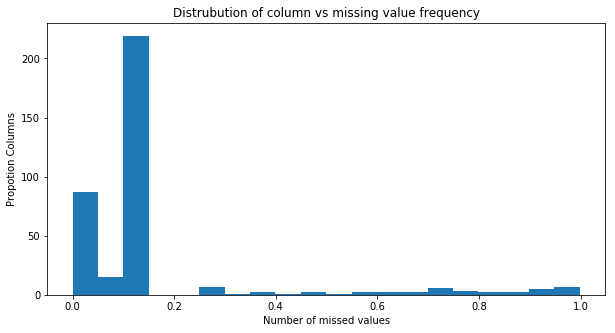

In [19]:
#plot Distrubution of column vs missing value frequency
plt.figure(figsize=(10,5))
plt.hist(missing_column_df , bins =20)
plt.ylabel('Propotion Columns')
plt.xlabel('Number of missed values')
plt.title("Distrubution of column vs missing value frequency")
plt.show()

  #### 0.3b : Row Wise Missing Value

In [20]:
# missing value percentage in each record /row
missing_row_df = dias.isnull().sum(axis=1)/dias.shape[1]

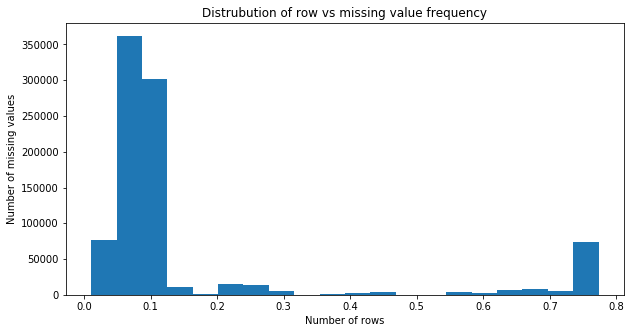

In [21]:
#plot Distrubution of row vs missing value frequency
plt.figure(figsize=(10,5))
plt.hist(missing_row_df , bins =20)
plt.ylabel('Number of missing values')
plt.xlabel('Number of rows')
plt.title("Distrubution of row vs missing value frequency")
plt.show()

  #### 0.3c : Remove  Missing Value

In [22]:
def remove_missing_value(df,true_df = True,row_thres = 0.2 ,col_thres =0.2,):
    """
    remove missing value columns and rows which exceeds a given theshold
    """
    col_to_drop = []
    if true_df:
        # missing value percentage in each feature /column
        missing_column_df = df.isnull().sum()/len(df)
    
        # remove columns having 
        col_to_drop = missing_column_df[missing_column_df > col_thres].index
        df = df.drop(col_to_drop,axis=1)
    # missing value percentage in each record /row
    missing_row_df = df.isnull().sum(axis=1)/df.shape[1]
    
    # remove rows  
    row_to_drop = missing_row_df[missing_row_df > row_thres].index 
    df = df.drop(row_to_drop, axis=0)
    
    return df, col_to_drop

In [23]:
#remove missing value columns and rows which exceeds a given theshold
dias_miss,col_to_drop = remove_missing_value(dias)

### 0.4 : Explore Categorical Columns

In [24]:
#given object type columns
object_type_col = [col for col in dias_miss.columns if dias_miss[col].dtype=="object"]

In [25]:
#stage1 filter 
for col in object_type_col:
        print("col:",col,"  Uni_val:",dias_miss[col].nunique(),"  Uni_vals: ",dias_miss[col].unique())    

col: CAMEO_DEU_2015   Uni_val: 45   Uni_vals:  ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '7A' '5D' '9E'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
col: CAMEO_DEUG_2015   Uni_val: 19   Uni_vals:  [8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 nan '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
col: CAMEO_INTL_2015   Uni_val: 43   Uni_vals:  [51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0 nan
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']
col: EINGEFUEGT_AM   Uni_val: 3854   Uni_vals:  ['1992-02-10 00:00:00' '1992-02-12 00:00:00' '1997-04-21 00:00:00' ...
 '2009-09-09 00:00:00' '2000-03-09 00:00:00' '2005-03-19 00:00:00']
col: OST_WEST_KZ   Uni_val: 2   Uni_vals:  ['W' 'O']


In [26]:
def reencode_cat_feat(df,col_to_drop):
    """
    encode categorical featues and drop the given columns
    """
    
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    df['EINGEFUEGT_AM'], _ = pd.factorize(pd.to_datetime(df['EINGEFUEGT_AM']).dt.year)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X': np.nan}).astype(float)
    
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX': np.nan}).astype(float)
    df['to_Wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(x/10))
    df['to_life_stage'] = df['CAMEO_INTL_2015'].apply(lambda x: x%10)
    
    df.drop("CAMEO_INTL_2015",axis=1, inplace = True)
    
    df.drop(col_to_drop, axis=1, inplace = True)
    return df

In [27]:
#encode categorical featues and drop the given columns
dias2 = reencode_cat_feat(dias_miss,["CAMEO_DEU_2015"])

### 0.5: Feature Scaling & Missing value Imputing

In [28]:
def impute_scale(df):
    """
    returns a imputed and scaled df
    """
    imputer = Imputer(strategy='median')
    scaler = StandardScaler()
    df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
    df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
    return df

In [29]:
#impute and scale df
dias3 = impute_scale(dias2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### 0.6 Putting it all Together


In [30]:
def clean_data(df,attribute_df = dias_attr,cols_to_drop = col_to_drop,is_test = False):
    """
    Overall cleaning fn
    
    inputs:
    df:dataframe to be cleaned
    attribute_df: dataframe contain the attribute details 
    cols_to_drop :columns to drop
    is_test = select variable to identify test dataset and perform transformations
    
    output:
    cleaned dataframe
    """
    df,_ = encode_missing_unknown(df,attribute_df)
    
    df = df.drop(cols_to_drop, axis=1)
    
    if is_test == False:
        df,_  = remove_missing_value(df,true_df=False)
    
    df = reencode_cat_feat(df,["CAMEO_DEU_2015"])
    
    df = impute_scale(df)

    return df

In [31]:
#clean customers dataframe
clean_customers = clean_data(customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],axis=1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [32]:
#clean train dataframe 
mailout_train_cleaned = clean_data(mailout_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [33]:
# Dump the dataframes to  pickle object .
pickle.dump(dias3, open("azdias_cleaned.pickle", "wb"))
pickle.dump(clean_customers, open("customers_cleaned.pickle", "wb"))
pickle.dump(mailout_train_cleaned, open("mailout_train_cleaned.pickle", "wb"))


## Part 1: Customer Segmentation Report

The main bulk of our analysis will come in this part of the project. Here, we should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, we should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [34]:
# load pickle objects
azdias_new = pickle.load(open("azdias_cleaned.pickle", "rb"))
customers_new = pickle.load(open("customers_cleaned.pickle", "rb"))

### 1.1: PCA

In [35]:
def perform_pca(n_components,data):
    """
    Transforms data using PCA to create n_components, and gives back thr
    transformed dataframe
    """
    pca = PCA(n_components)
    pca_fitted = pca.fit_transform(data)
    return pca, pca_fitted

In [36]:
pca_1 ,pca_1_fitted = perform_pca(None,azdias_new)

In [37]:
def scree_plot(pca):
    """
    plot Principal Component vs Explained Variance
    """
    
    num_components = pca.n_components_
    vals = pca.explained_variance_ratio_
    ind = np.arange(num_components)
    
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

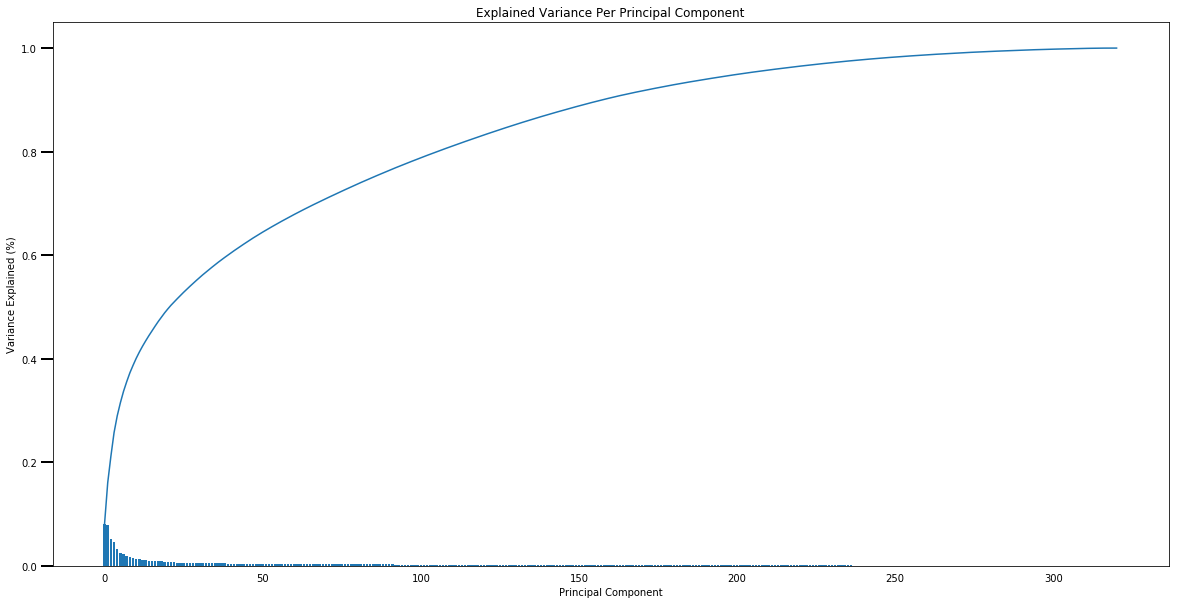

In [38]:
scree_plot(pca_1)

In [39]:
print("Total sum of Explained varience for first 5 components",pca_1.explained_variance_ratio_[:5].sum())
print("Total sum of Explained varience for first 10 components",pca_1.explained_variance_ratio_[:10].sum())
print("Total sum of Explained varience for first 50 components",pca_1.explained_variance_ratio_[:50].sum())
print("Total sum of Explained varience for first 100 components",pca_1.explained_variance_ratio_[:100].sum())
print("Total sum of Explained varience for first 200 components",pca_1.explained_variance_ratio_[:200].sum())

Total sum of Explained varience for first 5 components 0.2895336585545902
Total sum of Explained varience for first 10 components 0.38710462309754246
Total sum of Explained varience for first 50 components 0.6409151534414973
Total sum of Explained varience for first 100 components 0.785753850433983
Total sum of Explained varience for first 200 components 0.9483279514976463


#### Key Notes:
> - ~95% of variance is explained by first 200 components of pca

In [40]:
# Refit with 200 components
pca_2 ,pca_2_fitted = perform_pca(200,azdias_new)

In [41]:
# create dataframe containing explained varience by each featue
components_df = pd.DataFrame(np.round(pca_2.components_,4),columns = azdias_new.columns)
components_df["Explained Varience (%)"] = np.round(pca_2.explained_variance_ratio_.reshape(len(pca_2.components_), 1),4)*100

In [42]:
components_df.head(10)

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,to_Wealth,to_life_stage,Explained Varience (%)
0,-0.0233,0.0628,0.0837,0.0205,-0.0263,-0.0743,0.0818,-0.0026,0.0978,-0.0770,...,0.0799,0.0409,-0.0323,-0.0569,0.0860,0.0061,-0.0382,0.1356,-0.0788,8.15
1,0.0037,0.0094,0.0252,0.0113,-0.0104,-0.0135,0.0308,0.0018,-0.0021,-0.0083,...,0.0066,0.0167,0.0033,-0.0054,-0.0050,0.0020,0.0193,0.0010,0.0082,7.92
2,-0.0938,-0.0101,-0.0095,-0.0225,-0.0014,0.0063,-0.0073,-0.0106,0.0537,0.0819,...,-0.0239,-0.0007,0.0112,0.0802,0.0107,-0.0056,0.0152,0.0363,-0.0009,5.09
3,0.0136,0.0426,-0.0141,-0.0160,0.0751,0.0533,-0.0166,-0.0081,-0.0293,0.0159,...,0.0297,-0.1123,-0.0637,0.0292,0.0490,0.0082,-0.1920,-0.0136,-0.0319,4.56
4,-0.0548,-0.1092,0.0171,0.0143,0.0598,0.1602,0.0168,0.0127,0.0810,-0.0630,...,-0.1838,-0.0722,0.0192,-0.0701,-0.0573,-0.0106,0.0205,0.0139,0.0080,3.23
5,-0.1246,0.0346,0.0124,0.0124,-0.0149,-0.0501,0.0148,0.0020,0.0722,0.0419,...,0.0158,0.0121,-0.0193,-0.0140,0.0212,-0.0021,-0.0369,-0.0227,0.0510,2.54
6,-0.0063,-0.0078,-0.0058,-0.0006,-0.0264,0.0014,-0.0071,0.0061,-0.0050,0.0012,...,-0.0733,0.0547,0.0055,0.0180,-0.0463,-0.3472,-0.0305,0.0009,-0.0180,2.21
7,0.0143,0.0145,-0.0187,-0.0064,-0.0119,-0.0229,-0.0164,0.0002,0.0948,-0.0482,...,0.0072,0.0182,-0.0126,-0.1459,-0.0086,-0.0323,-0.0501,-0.0344,0.0988,1.86
8,0.0762,-0.0043,0.0468,0.0021,0.0074,0.0227,0.0455,-0.0071,-0.0118,-0.0387,...,0.0136,-0.0125,0.0200,-0.0275,0.0041,-0.0313,0.0082,0.0226,-0.0212,1.70
9,-0.0176,0.0065,-0.0601,0.0050,-0.0153,-0.0425,-0.0615,0.0104,-0.0069,-0.0151,...,0.0307,0.0199,-0.0028,-0.0174,-0.0283,0.0187,-0.0189,-0.0908,0.0209,1.44


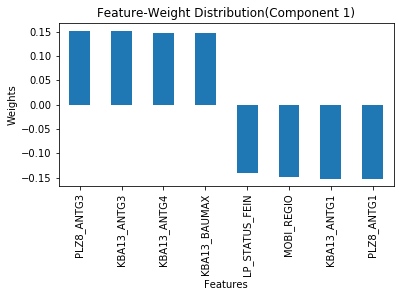

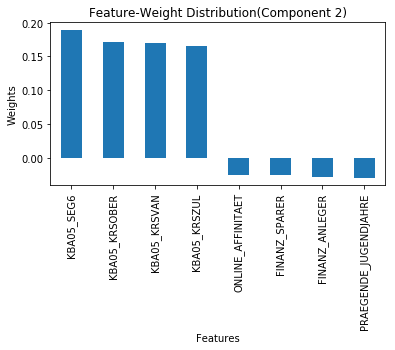

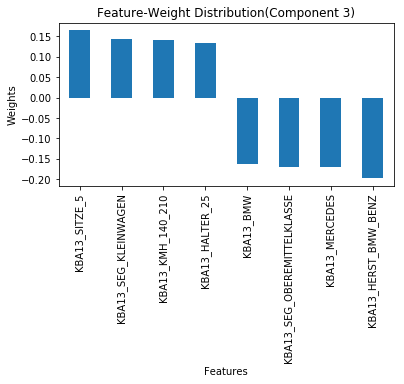

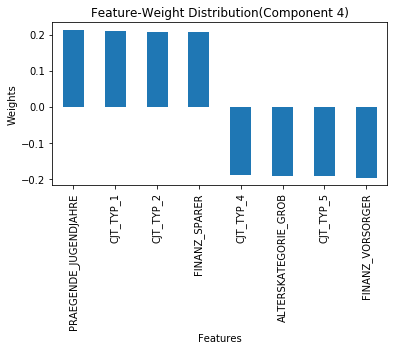

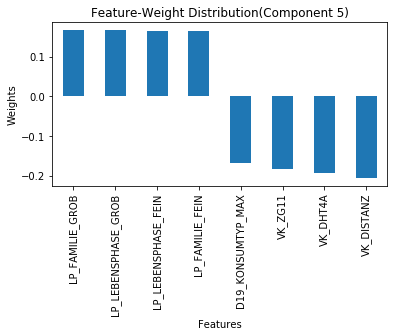

In [43]:
#plot top 5 features explained varience for each component
for i in range(5):
    top_5_series = components_df.loc[i][:-1].sort_values(ascending=False).iloc[[0, 1, 2, 3, -4, -3, -2, -1]]
    
    
    plt.figure(figsize = (6,3))
    top_5_series.plot(kind = 'bar');
    plt.xlabel("Features")
    plt.ylabel("Weights")
    plt.title("Feature-Weight Distribution(Component "+str(i+1)+")" )

#### Key Notes:
There is no clear cut way to choose the number of components to keep when performing PCA.We have select the number of components which explained ~90% of the variance,ie 200 components

### 1.2: K-Means Clustering

In [44]:
num_clusters = []
scores = []
k_fitted = []

def plot_elbow(data):
    """
    elbow plot to determine the best number of clusters
    """
    
    for cluster in range(2,20,2):
        print(cluster)
        start = time.time()
        kmeans = KMeans(n_clusters=cluster)
        model = kmeans.fit(data)
        score = abs(model.score(data))
        scores.append(score)
        num_clusters.append(cluster)
        k_fitted.append(model)
        end = time.time()
        elapsed_time = end - start
        print(elapsed_time)

    plt.plot(num_clusters, scores, linestyle='--', marker='o');
    plt.xlabel('Number of clusters');
    plt.ylabel('SSE');
    plt.title('Score vs. Number of Clusters');

2
140.15757012367249
4
341.740172624588
6
423.46074509620667
8
755.4455895423889
10
1089.3896887302399
12
1126.2536499500275
14
1172.1288723945618
16
1585.7443945407867
18
1406.320217847824


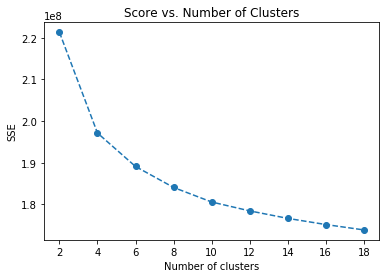

In [47]:
# Investigate the change in within-cluster distance across number of clusters.
plot_elbow(pca_2_fitted)

In [48]:
n_cluster = 9
kmeans = KMeans(n_clusters=n_cluster, random_state=12)

In [49]:
# apply kmeans with 9 clusters for the general population
kmeans_model = kmeans.fit(pca_2_fitted)
general_preds = kmeans_model.predict(pca_2_fitted)

In [50]:
#apply pca and kmeans model to customers data

customers_pca = pca_2.transform(customers_new)
customers_preds = kmeans_model.predict(customers_pca)

#### Key Notes :
We have chosen number clusters as 9 from the elbow plot

### 1.3: Compare Customer Data to General Population Data

In [51]:
# create  propotion  dataframe
prop_general = pd.DataFrame(general_preds)[0].value_counts().sort_index()/pca_2_fitted.shape[0]
prop_customers = pd.DataFrame(customers_preds)[0].value_counts().sort_index()/customers_pca.shape[0]

prop_df = pd.DataFrame()
prop_df["cluster"] = prop_general.index
prop_df["prop_general"] = prop_general
prop_df["prop_customers"] = prop_customers
prop_df.set_index("cluster",inplace = True)
prop_df

,prop_general,prop_customers
cluster,,
0,0.159415,0.212717
1,0.140193,0.178327
2,0.018086,0.006454
3,0.074958,0.034484
4,0.126466,0.087496
5,0.144623,0.153941
6,0.071836,0.047011
7,0.165633,0.124409
8,0.098788,0.155163


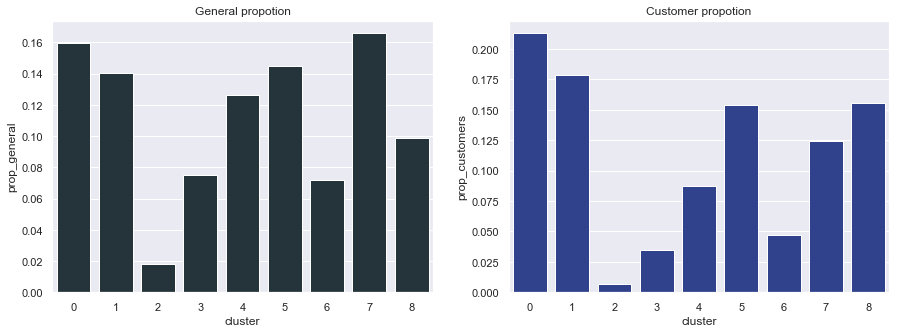

In [52]:
# plot porotions in clusters in general and customers
plt.figure(figsize = (15, 5))
sns.set(style="darkgrid")
 
plt.subplot(1,2,1)
sns.barplot(x = prop_df.index ,y = prop_df.prop_general,color='#21353e')
plt.title("General propotion")

plt.subplot(1,2,2)
sns.barplot(x = prop_df.index ,y = prop_df.prop_customers,color='#21399a' )
plt.title("Customer propotion")
plt.show()

##### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

In [53]:
# overrepresented groups
overrepresented_df = pd.DataFrame((prop_df.prop_customers-prop_df.prop_general)*100,
                                  columns = ["overrepresent %"]).sort_values(by="overrepresent %",
                                                                             ascending =False).reset_index(drop = False)
overrepresented_df

,cluster,overrepresent %
0,8,5.637495
1,0,5.330164
2,1,3.813357
3,5,0.931725
4,2,-1.163228
5,6,-2.482559
6,4,-3.897043
7,3,-4.047465
8,7,-4.122446


In [54]:
def plot_feat_values(kmeans,n_cluster,df,pca):
    """
    plot columns each associated with each cluster
    """
    weight = kmeans.cluster_centers_[n_cluster]
    top_feat = pd.DataFrame(pca.inverse_transform(weight),index = df.columns,
                 columns=["values"]).sort_values("values",ascending=False)
    
    top_feat = pd.concat([top_feat.head(10),top_feat.tail(10)])
    top_feat["Description" ] = np.nan
    #top_feat["Additional notes"] = np.nan
    
    for index in top_feat.index:
        if index in dias_attr_detailed.Attribute.to_list():
            top_feat.loc[index,"Description"] = dias_attr_detailed[dias_attr_detailed.Attribute == index]["Description"].iloc[0]
            #top_feat.loc[index ,"Additional notes"] = dias_attr_detailed[dias_attr_detailed.Attribute == index]["Additional notes"].iloc[0]
                                                                                                                      
    #plot graph
    plt.figure(figsize=(15,4))
    sns.set(style="darkgrid")
    sns.barplot(x = top_feat.index , y = top_feat["values"],color='#21353e', errwidth=1 ,capsize =7)
    plt.xticks(rotation='vertical')
    plt.show()
    return top_feat
                                                                                                                              
                                                                                                                              

#### Interpretation: overrepresented clusters

#### cluster 7 investigation

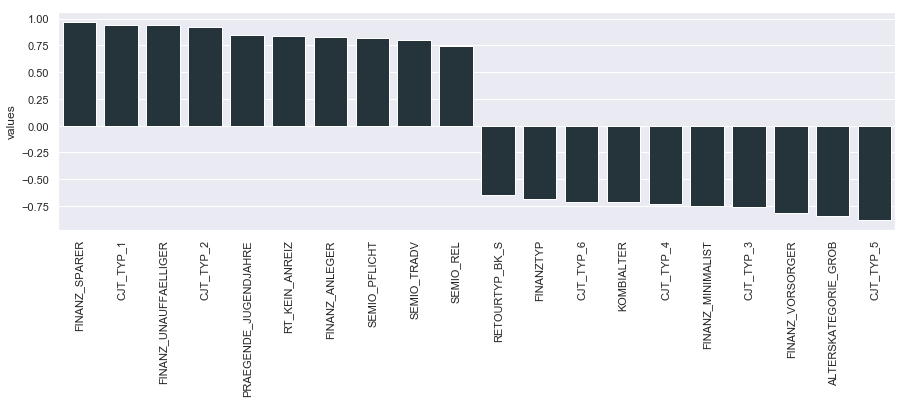

,values,Description
FINANZ_SPARER,0.965314,financial typology: money saver
CJT_TYP_1,0.938337,NaN
FINANZ_UNAUFFAELLIGER,0.937518,financial typology: unremarkable
CJT_TYP_2,0.919419,NaN
PRAEGENDE_JUGENDJAHRE,0.843148,dominating movement in the person's youth (ava...
RT_KEIN_ANREIZ,0.841556,NaN
FINANZ_ANLEGER,0.826326,financial typology: investor
SEMIO_PFLICHT,0.820858,affinity indicating in what way the person is ...
SEMIO_TRADV,0.802840,affinity indicating in what way the person is ...
SEMIO_REL,0.739600,affinity indicating in what way the person is ...


In [55]:
plot_feat_values(kmeans_model,7,customers_new,pca_2)

**cluster 7 mostly associated with columns containing upper middle class car owners**

#### cluster 1 investigation

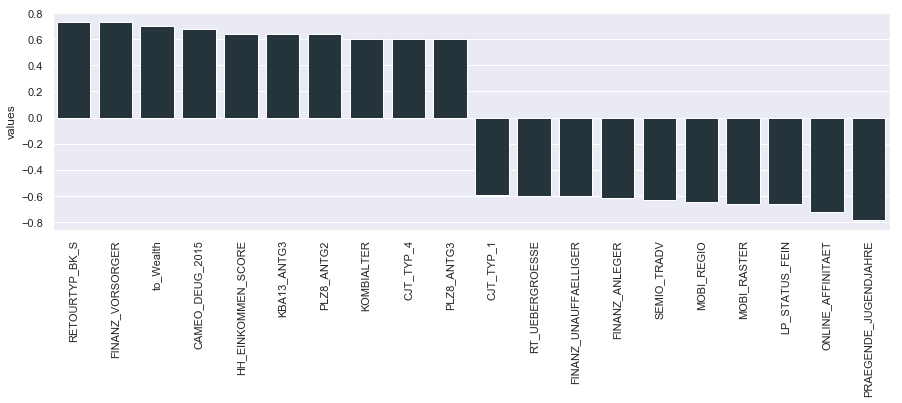

,values,Description
RETOURTYP_BK_S,0.731182,return type
FINANZ_VORSORGER,0.729365,financial typology: be prepared
to_Wealth,0.704297,NaN
CAMEO_DEUG_2015,0.677267,CAMEO_4.0: uppergroup
HH_EINKOMMEN_SCORE,0.644609,estimated household_net_income
KBA13_ANTG3,0.643527,NaN
PLZ8_ANTG2,0.638116,number of 3-5 family houses in the PLZ8
KOMBIALTER,0.605313,NaN
CJT_TYP_4,0.600258,NaN
PLZ8_ANTG3,0.599884,number of 6-10 family houses in the PLZ8


In [56]:
plot_feat_values(kmeans_model,1,customers_new,pca_2)

**cluster 1 doesn't explain a clear cut common features,but it kind of associated with family finance and number of dependent members** 

#### Interpretation: underrepresented clusters

#### cluster 2 investigation

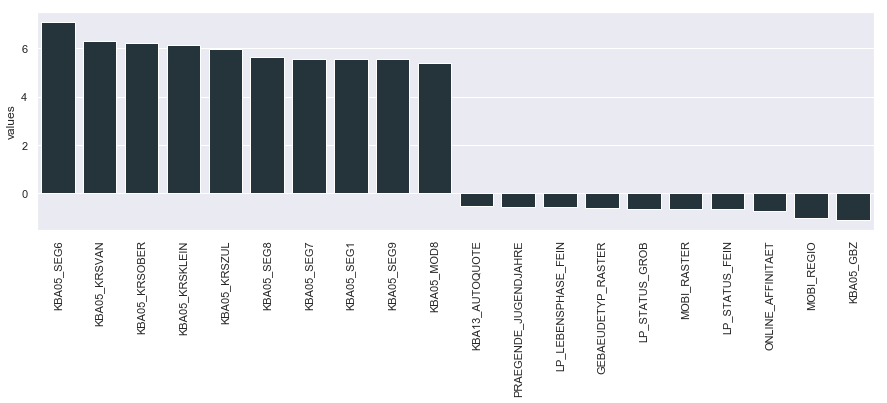

,values,Description
KBA05_SEG6,7.078667,share of upper class cars (BMW 7er etc.) in th...
KBA05_KRSVAN,6.290170,share of vans (referred to the county average)
KBA05_KRSOBER,6.225751,share of upper class cars (referred to the cou...
KBA05_KRSKLEIN,6.119932,share of small cars (referred to the county av...
KBA05_KRSZUL,5.965094,share of newbuilt cars (referred to the county...
KBA05_SEG8,5.653265,share of roadster and convertables in the micr...
KBA05_SEG7,5.573305,share of all-terrain vehicles and MUVs in the ...
KBA05_SEG1,5.567188,share of very small cars (Ford Ka etc.) in the...
KBA05_SEG9,5.552383,share of vans in the microcell
KBA05_MOD8,5.372722,share of vans (in an AZ specific definition)


In [57]:
plot_feat_values(kmeans_model,2,customers_new,pca_2)

**cluster 2 have more bias towards financial typology related features.**

#### cluster 0 investigation

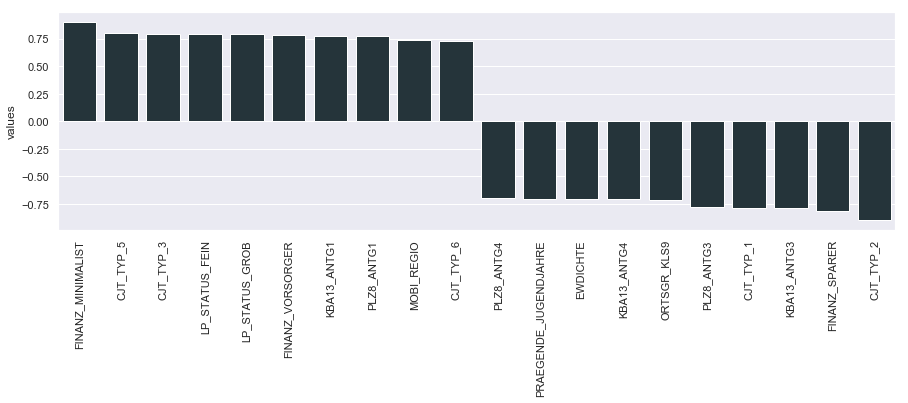

,values,Description
FINANZ_MINIMALIST,0.898786,financial typology: low financial interest
CJT_TYP_5,0.804882,NaN
CJT_TYP_3,0.794389,NaN
LP_STATUS_FEIN,0.790929,social status fine
LP_STATUS_GROB,0.789994,social status rough
FINANZ_VORSORGER,0.779672,financial typology: be prepared
KBA13_ANTG1,0.777778,NaN
PLZ8_ANTG1,0.772870,number of 1-2 family houses in the PLZ8
MOBI_REGIO,0.739028,moving patterns
CJT_TYP_6,0.731710,NaN


In [58]:
plot_feat_values(kmeans_model,0,customers_new,pca_2)

**cluster 0 relates to lower middle class car owners.**

## Part 2: Supervised Learning Model

Now that we've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, we'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [59]:
mailout_train = pd.read_csv("mailout_train.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [60]:
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [61]:
del mailout_train["Unnamed: 0"]

In [62]:
mailout_train.info(),mailout_train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


(None, (42962, 367))

In [63]:
#train =clean_data(mailout_train)
train = pickle.load(open("mailout_train_cleaned.pickle", "rb"))

In [64]:
train.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,to_Wealth,to_life_stage
0,-1.651421,-0.297447,0.553403,-0.131448,-0.224681,-0.752104,0.475919,-0.091964,-0.043016,0.336739,...,-0.832875,0.740317,0.256338,-0.526493,0.203860,-0.112211,0.852657,0.585913,0.027013,0.507855
1,-1.651100,1.442955,-0.378573,-0.131448,-0.224681,-0.017592,-0.370792,-0.091964,-1.010031,0.336739,...,-0.832875,-0.388227,0.256338,1.439834,-1.431808,-0.112211,0.852657,-0.645686,0.027013,-0.901719
2,-1.650899,-0.297447,-0.445143,-0.131448,-0.224681,-1.486616,-0.370792,-0.091964,0.923999,-1.486251,...,-0.436034,0.740317,0.256338,-1.018075,0.203860,-0.112211,-1.172804,0.585913,-1.347202,0.507855
3,-1.663581,-0.297447,-0.178864,-0.131448,-0.224681,-0.017592,-0.159114,-0.091964,0.923999,-1.030504,...,3.135542,0.740317,0.256338,-1.509657,0.203860,-0.112211,0.852657,0.585913,-1.347202,0.507855
4,-1.650618,-0.297447,3.083053,-0.131448,-0.224681,-0.752104,2.663256,-0.091964,-0.043016,-0.119008,...,-0.832875,0.740317,0.256338,-0.526493,0.203860,-0.112211,-1.172804,-0.645686,0.714121,-1.606506


In [65]:
train['RESPONSE'] = train["RESPONSE"].map(lambda x : 1 if x>0 else 0)

In [66]:
train['RESPONSE'].value_counts()

0    34389
1      433
Name: RESPONSE, dtype: int64

In [67]:
y = train.pop('RESPONSE')
X = train

### 2.1: Classification

In [68]:
def classifier(clf, param_grid, X_train=X, y_train=y):

    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    end = time.time()
    print("Time taken:",end-start)
    
    return grid.best_estimator_

In [69]:
# LogisticRegression
lg = LogisticRegression(random_state=12)
print(classifier(lg, {}))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

0.6457627699499301
Time taken: 59.44636559486389
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=12, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [70]:
# RandomForest
rf = RandomForestClassifier()
print(classifier(rf, {}))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

0.5208129374684245
Time taken: 8.23593521118164
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [75]:
# AdaBoostClassifier

ada = AdaBoostClassifier()
print(classifier(ada, {}))

0.6766023555249375
Time taken: 72.06990933418274
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


In [71]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier()
print(classifier(gbc, {}))

0.6968345056718852
Time taken: 206.58053493499756
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [72]:
# SupportVectorMachine
svc = SVC()
print(classifier(svc, {}))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

0.5968993328890705
Time taken: 2154.7815544605255
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [77]:
#Tune AdaBoostClassifier using GridSearchCV

start = time.time()

param_grid = {'algorithm': ['SAMME.R' ,'SAMME'],
             'learning_rate': [0.1,0.5,1.0]
             }

grid = GridSearchCV(estimator=AdaBoostClassifier(random_state=12, n_estimators =200 ), param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

end = time.time()
tuning_time = end - start
tuning_time

0.7151853708688194
AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=200, random_state=12)


1227.0155520439148

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [78]:
mailout_test = pd.read_csv('mailout_test.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
mailout_test.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [80]:
del mailout_test['Unnamed: 0']

In [81]:
mailout_test.shape

(42833, 366)

In [82]:
# extract lnr for later generation of the competition result file
lnr = mailout_test.LNR

In [83]:
cleaned_mailout_test = clean_data(mailout_test,is_test = True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [84]:
cleaned_mailout_test.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,to_Wealth,to_life_stage
0,-1.665871,-0.271646,-0.287584,-0.120872,-0.206929,-0.015838,-0.277275,-0.088595,-0.034350,0.793087,...,0.532270,0.039775,0.659184,0.244893,-0.475955,0.178441,-1.213276,0.728696,-1.494812,-0.309375
1,-1.665225,-0.271646,1.038302,-0.120872,-0.206929,-0.819601,1.202365,-0.088595,1.024156,1.293157,...,-0.803958,-0.820022,0.659184,0.244893,0.578160,0.178441,-1.213276,0.728696,0.025539,-1.829213
2,-1.677546,4.719141,-0.287584,-0.120872,-0.206929,1.591688,-0.277275,-0.088595,1.024156,-1.707265,...,0.532270,0.039775,-1.591635,0.244893,0.051102,0.178441,0.824215,0.728696,0.785714,-1.829213
3,-1.677344,3.471445,-0.361244,-0.120872,-0.206929,-1.623364,-0.355151,-0.088595,1.024156,-1.707265,...,0.532270,0.039775,0.659184,0.244893,-1.003012,0.178441,0.824215,0.728696,-1.494812,-0.309375
4,-1.677021,-0.271646,-0.361244,-0.120872,-0.206929,1.591688,-0.355151,-0.088595,-0.034350,0.793087,...,-0.135844,0.039775,-1.028930,0.244893,1.632274,1.070811,0.824215,0.728696,0.025539,-1.829213


In [85]:
# and predict
best_model = grid.best_estimator_
best_model.fit(X,y)
preds = best_model.predict_proba(cleaned_mailout_test)
preds[:10]

array([[0.61010636, 0.38989364],
       [0.61010636, 0.38989364],
       [0.66366288, 0.33633712],
       [0.66392168, 0.33607832],
       [0.61130806, 0.38869194],
       [0.66468946, 0.33531054],
       [0.61130806, 0.38869194],
       [0.61092061, 0.38907939],
       [0.61201406, 0.38798594],
       [0.61092061, 0.38907939]])

In [86]:
result = pd.DataFrame({'LNR':lnr.astype(np.int32), 'RESPONSE':preds[:, 1]})
result.to_csv('result.csv', index = False)
result.head()

,LNR,RESPONSE
0,1754,0.389894
1,1770,0.389894
2,1465,0.336337
3,1470,0.336078
4,1478,0.388692
